In [80]:
import os

import arviz as az
import matplotlib.pyplot as plt
from matplotlib import gridspec
import numpy as np
import pandas as pd
import pymc as pm
import pytensor.tensor as pt
import libpysal
from geopandas import read_file
from datetime import datetime
import geobr


In [2]:
# temporal expanse of all data sets in months
T_value = 120

def get_biome_data(data):

    df = pd.read_csv(data, sep='\t')

    vec_LUT = df["vec_LUT"].to_numpy()
    vec_Prec = df["vec_Prec"].to_numpy()
    vec_Temp = df["vec_Temp"].to_numpy()
    vec_Humid = df["vec_Humid"].to_numpy()
    vec_Speed = df["vec_Speed"].to_numpy()
    vec_Area = df["vec_Area"].to_numpy()
    
    data = [vec_LUT, vec_Prec, vec_Temp, vec_Humid, vec_Speed, vec_Area]
    
    t = df["vec_Month"].to_numpy()

    munic = df["vec_Munic"].to_numpy()

    FS = df["vec_FS"].to_numpy()
    
    return [data, t, munic, FS]


def get_W(biome_W):
    return np.array( [np.array(biome_W.iloc[i,0].split(','), dtype='int')
                                   for i in range(0, biome_W.shape[0])])


# Biome data
Amazon_Rainforest = get_biome_data('Data/Data_Amazonia.txt')
Dry_Scrublands = get_biome_data('Data/Data_Caatinga.txt')
Tropical_Savanna = get_biome_data('Data/Data_Cerrado.txt')
Atlantic_Forest = get_biome_data('Data/Data_Mata_Atlantica.txt')
Pampa = get_biome_data('Data/Data_Pampas.txt')
Wetlands = get_biome_data('Data/Data_Pantanal.txt')

# neighbourhood matrices for biomes
Amazon_Rainforest_W = get_W(pd.read_csv('Data/W_Amazonia.csv', sep='\t'))
Dry_Scrublands_W = get_W(pd.read_csv('Data/W_Caatinga.csv', sep='\t'))
Tropical_Savanna_W = get_W(pd.read_csv('Data/W_Cerrado.csv', sep='\t'))
Atlantic_Forest_W = get_W(pd.read_csv('Data/W_Mata_Atlantica.csv', sep='\t'))
Pampa_W = get_W(pd.read_csv('Data/W_Pampas.csv', sep='\t'))
Wetlands_W = get_W(pd.read_csv('Data/W_Pantanal.csv', sep='\t'))

In [3]:

# defining biome 
biome = Amazon_Rainforest
W = np.array(Amazon_Rainforest_W)


# biome dependent input data
data = biome[0]
t = biome[1]
FS = biome[-1]

data_length = len(FS)
n_munic = np.size(W, 0)

LUT = data[0]
HUMID = data[3]
TEMP = data[2]
area = data[-1]



# Big Model

In [5]:


with pm.Model(coords={"area_idx": np.arange(data_length)}) as car_model:
    beta0 = pm.Normal("beta0", mu=0.0, tau=1.0e-5)
    beta1 = pm.Normal("beta1", mu=0.0, tau=1.0e-5)
    beta2 = pm.Normal("beta2", mu=0.0, tau=1.0e-5)
    beta3 = pm.Normal("beta3", mu=0.0, tau=1.0e-5)

    rho_int = pm.Uniform("rho_int", lower=0, upper=1)
    rho_slo = pm.Uniform("rho_slo", lower=0, upper=1)

    tau_int = pm.InverseGamma("tau_int", alpha=1, beta=0.01)
    tau_slo = pm.InverseGamma("tau_slo", alpha=1, beta=0.01)

    alpha = pm.Normal("alpha", mu=0, tau=1.0e-3)

    # Define the CAR prior mean and variance
    sum_weights = np.sum(W, axis=1)
    phi_mean = pm.math.dot(W, np.zeros(n_munic))  # Will get updated iteratively
    delta_mean = pm.math.dot(W, np.zeros(n_munic))

    # Define CAR prior for each phi_i iteratively
    phi_base = pm.Normal( "phi_base",
        mu=(rho_int * pm.math.dot(W, phi_mean)) / (rho_int * sum_weights + (1 - rho_int)),
        sigma=pm.math.sqrt(tau_int**2 / (rho_int * sum_weights + (1 - rho_int))),
        shape=n_munic)
    
    phi = pm.Deterministic("phi", pm.math.concatenate([phi_base] * T_value))
    
    delta_base = pm.Normal( "delta_base",
        mu=(rho_slo * pm.math.dot(W, delta_mean)) / (rho_slo * sum_weights + (1 - rho_slo)),
        sigma=pm.math.sqrt(tau_slo**2 / (rho_slo * sum_weights + (1 - rho_slo))),
        shape=n_munic)
    
    delta = pm.Deterministic("delta", pm.math.concatenate([delta_base] * T_value))

    # exponential of the linear predictor -> the mean of the likelihood
    mu = pm.Deterministic("mu", pt.exp(beta0 + beta1*LUT + beta2*HUMID + beta3*TEMP + phi + (alpha + delta)*(t-(T_value/2+0.5))/T_value)*area, dims="area_idx")

    # likelihood of the observed data
    y_i = pm.Poisson("y_i", mu=mu, observed=FS, dims="area_idx")

    # sampling the model
    big_idata = pm.sample(1000, tune=500, return_inferencedata=True, idata_kwargs={"log_likelihood": True}, progressbar=True,
                          initvals={"beta0": -7.6, "beta1": -0.0047, "beta2": -0.0622, "beta3": 0.0211,"alpha": -0.417,
                                                "rho_int":0.02, "rho_slo":0.03, "tau_int":1.19, "tau_slo":1.02, "phi_base":np.zeros(n_munic), "delta_base":np.zeros(n_munic)})

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta0, beta1, beta2, beta3, rho_int, rho_slo, tau_int, tau_slo, alpha, phi_base, delta_base]


Output()

Sampling 4 chains for 500 tune and 1_000 draw iterations (2_000 + 4_000 draws total) took 3512 seconds.
Chain 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


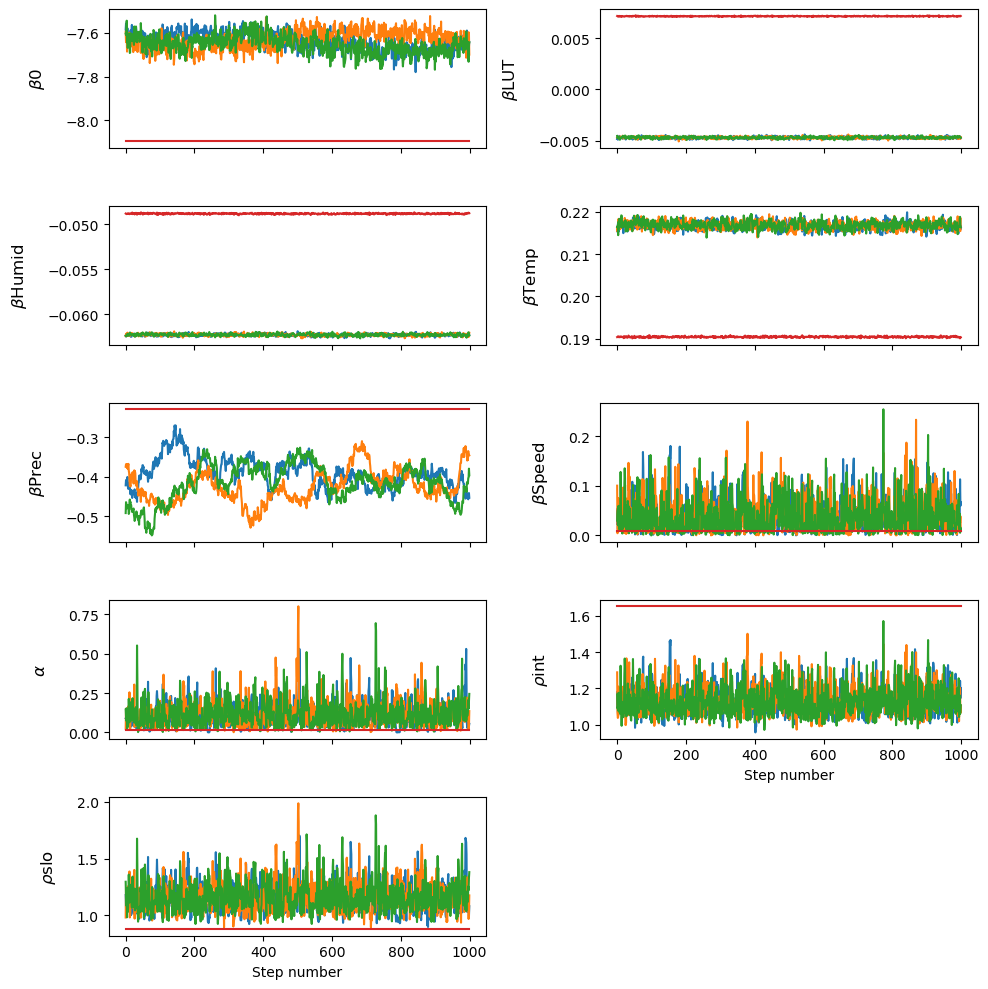

In [35]:

labels = [r"$\beta0$", r"$\beta{\text{LUT}}$", r"$\beta{\text{Humid}}$", r"$\beta{\text{Temp}}$",
          r"$\beta{\text{Prec}}$", r"$\beta{\text{Speed}}$", r"$\alpha$", r"$\rho{\text{int}}$",
          r"$\rho{\text{slo}}$", r"$\tau{\text{int}}$", r"$\tau{\text{slo}}$"]

fig, axes = plt.subplots(5, 2, figsize=(10, 10), sharex=True)
axes = axes.flatten()

param_names = ['beta0', 'beta1', 'beta2', 'beta3', 'alpha', 
               'rho_int', 'rho_slo', 'tau_int', 'tau_slo']

for idx, ax in enumerate(axes):
    if idx < len(param_names):
        param = param_names[idx]
        for i in range(4):  # Assuming 4 chains
            ax.plot(range(len(getattr(big_idata.posterior, param)[i])),
                    getattr(big_idata.posterior, param)[i])
        ax.set_ylabel(labels[idx], rotation=90, labelpad=20, fontsize=12, va='center')
    else:
        ax.axis('off')  # Turn off unused axes

axes[-3].tick_params(axis='x', which='both', bottom=True, labelbottom=True)
axes[-3].set_xlabel("Step number")
axes[-2].set_xlabel("Step number")
plt.tight_layout()
plt.show()




In [29]:

Beta0 = big_idata.posterior.beta0.values.flatten()
Beta1 = big_idata.posterior.beta1.values.flatten()
Beta2 = big_idata.posterior.beta2.values.flatten()
Beta3 = big_idata.posterior.beta3.values.flatten()
Phi = np.concatenate((big_idata.posterior.phi_base.values[0],big_idata.posterior.phi_base.values[1],
                      big_idata.posterior.phi_base.values[2]))
Delta = np.concatenate((big_idata.posterior.delta_base.values[0],big_idata.posterior.delta_base.values[1],
                      big_idata.posterior.delta_base.values[2]))
Alpha = big_idata.posterior.alpha.values.flatten()
Rho_int = big_idata.posterior.rho_int.values.flatten()
Rho_slo = big_idata.posterior.rho_slo.values.flatten()
Tau_int = big_idata.posterior.tau_int.values.flatten()
Tau_slo = big_idata.posterior.tau_slo.values.flatten()


In [93]:
print(len(Phi[0]))

558


In [32]:
current_time = datetime.now()
formatted_time = current_time.strftime("%H:%M")

df = pd.DataFrame({
    "beta0": big_idata.posterior.beta0.values.flatten(),
    "beta_LUT": big_idata.posterior.beta1.values.flatten(),
    "beta_Humid": big_idata.posterior.beta2.values.flatten(),
    "beta_TEMP": big_idata.posterior.beta3.values.flatten(),
    "alpha": big_idata.posterior.alpha.values.flatten(),
    "rho_int": big_idata.posterior.rho_int.values.flatten(),
    "rho_slo": big_idata.posterior.rho_slo.values.flatten(),
    "tau_int": big_idata.posterior.tau_int.values.flatten(),
    "tau_slo": big_idata.posterior.tau_slo.values.flatten(),
})

# Save to CSV
df.to_csv("csv/samples_big_no_phi_delta"+str(formatted_time)+".csv", index=False)


dphi = pd.DataFrame(Phi)

# Save the DataFrame to a CSV file
dphi.to_csv("csv/samples_big_phi"+str(formatted_time)+".csv", index=False, header=False)

ddelta = pd.DataFrame(Delta)

# Save the DataFrame to a CSV file
ddelta.to_csv("vsc/samples_big_delta"+str(formatted_time)+".csv", index=False, header=False)


In [45]:
# remove bad walker
subset_big_idata = big_idata.sel(chain=slice(0, 2))

4000
3000


In [95]:

Phi_mean = np.mean(Phi, axis=0)

Delta_mean = np.mean(Delta, axis=0)

print(Phi_mean[0])

1.4479803438947578


In [91]:


dphi_mean = pd.DataFrame(Phi_mean)

# Save the DataFrame to a CSV file
dphi_mean.to_csv("csv/samples_big_phi_mean"+str(formatted_time)+".csv", index=False, header=False)

ddelta_mean = pd.DataFrame(Delta_mean)

# Save the DataFrame to a CSV file
ddelta_mean.to_csv("csv/samples_big_delta_mean"+str(formatted_time)+".csv", index=False, header=False)



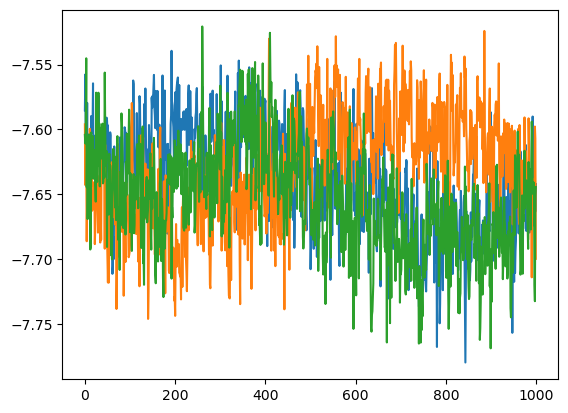

In [47]:

plt.figure()
for i in range(3): 
    plt.plot(range(len(subset_big_idata.posterior.beta0[i])),subset_big_idata.posterior.beta0[i])
plt.show()

In [48]:

waic_big_model = az.waic(subset_big_idata)

print(waic_big_model)

Computed from 3000 posterior samples and 66960 observations log-likelihood matrix.

          Estimate       SE
elpd_waic -805858.52  12964.92
p_waic    48417.23        -

There has been a warning during the calculation. Please check the results.


/opt/anaconda3/envs/pymc_env/lib/python3.12/site-packages/arviz/stats/stats.py:1653: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


In [78]:

print(big_idata.log_likelihood.y_i.values.flatten())

mean_deviance = -2*np.mean(big_idata.log_likelihood.y_i.values.flatten())


<xarray.DataArray 'y_i' (chain: 4, draw: 1000, area_idx: 66960)> Size: 2GB
array([[[ -3.29925631,  -0.96890038,  -1.88604998, ..., -47.16004422,
          -1.00000902,  -7.34525187],
        [ -3.44302831,  -1.07008489,  -1.65536285, ..., -45.94319981,
          -1.00000224,  -8.32152465],
        [ -2.97076265,  -1.1826225 ,  -1.80035774, ..., -47.71181277,
          -1.00013173,  -7.78122836],
        ...,
        [ -3.19561366,  -1.10817372,  -1.69313076, ..., -46.46334592,
          -1.01581867,  -8.39463512],
        [ -3.7293752 ,  -1.11570341,  -1.8213081 , ..., -46.08406954,
          -1.00890415,  -9.05861415],
        [ -3.56018957,  -1.25263287,  -1.80463419, ..., -47.97059782,
          -1.01268795,  -8.86257832]],

       [[ -3.07285543,  -1.23495853,  -1.73674042, ..., -47.26808622,
          -1.00510545, -10.87275927],
        [ -3.56304232,  -0.88401839,  -1.78106564, ..., -46.00650597,
          -1.00363172,  -7.35397963],
        [ -3.52226629,  -0.97511362,  -1.73528

In [ ]:

def give_Mu():

    Mu = np.zeros((len(Beta0), T_value*n_munic))

    for i in range(len(Mu)):

        Mu[i] = np.exp(Beta0[i] + Beta1[i]*LUT + Beta2[i]*HUMID + Beta3[i]*TEMP + 
                       np.concatenate([Phi[i]] * T_value) + (Alpha[i] + np.concatenate([Delta[i]] * T_value))*(t-(T_value/2+0.5))/T_value)*area
        
    return Mu


Mu = give_Mu()

In [62]:

def give_MU_month_tot():

    MU_month_tot = np.zeros((len(Beta0), T_value))

    for i in range(T_value):
        for k in range(len(Mu)):

            MU_month_tot[k][i] = sum(Mu[k][(i-1)*n_munic: i*n_munic])/n_munic

    return MU_month_tot


MU_month_tot = give_MU_month_tot()


In [ ]:




def give_avg_month_cal(Mu_new):

    Mu_avg_month_cal = np.zeros(12)

    for k in range(10):
            
        temp = np.zeros(12*n_munic)

        temp += Mu_new[k*n_munic*12, (k+1)*n_munic*12]

        for i in range(12):

            Mu_avg_month_cal[i] += sum(temp[i*n_munic:(i+1)*n_munic])/(n_munic*10)
    
    return Mu_avg_month_cal

Mu_avg_month_cal = give_avg_month_cal(Mu_new)
FS_avg_month_cal = give_avg_month_cal(FS)
    

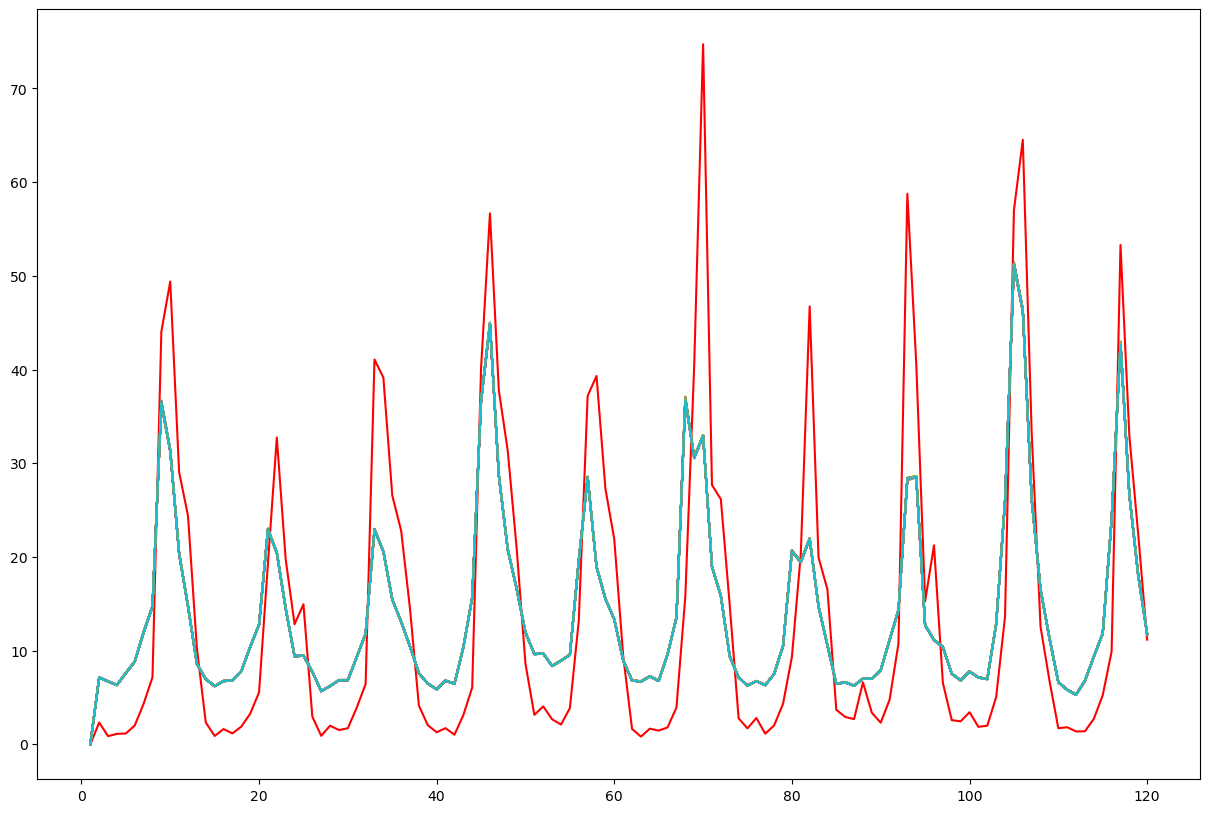

In [69]:

""" q = [0.025, 0.16, 0.84, 0.975]
model_quantiles = np.quantile(MU_month_tot, q=q, axis=0)
 """

plt.figure(figsize=(15, 10))
plt.plot(range(1, T_value+1), np.array([sum(FS[(i-1)*n_munic: i*n_munic])/n_munic for i in range(T_value)]), color='r')
for i in range(30):
    plt.plot(range(1, T_value+1), MU_month_tot[i*100])
plt.show()

In [78]:

RANDOM_SEED = 58
rng = np.random.default_rng(RANDOM_SEED)

with car_model:
    ppc = pm.sample_posterior_predictive(big_idata, extend_inferencedata=True, random_seed=rng)



Sampling: [y_i]


Output()

In [85]:


PPC_FS = np.concatenate((ppc.posterior_predictive.y_i.values[0] ,ppc.posterior_predictive.y_i.values[1] ,
                         ppc.posterior_predictive.y_i.values[2] ,ppc.posterior_predictive.y_i.values[3]))

def give_PPC_FS_month_tot():

    PPC_FS_month_tot = np.zeros((len(Beta0), T_value))

    for i in range(T_value):
        for k in range(len(Mu)):

            PPC_FS_month_tot[k][i] = sum(PPC_FS[k][(i-1)*n_munic: i*n_munic])/n_munic

    return PPC_FS_month_tot


PPC_FS_month_tot = give_PPC_FS_month_tot()


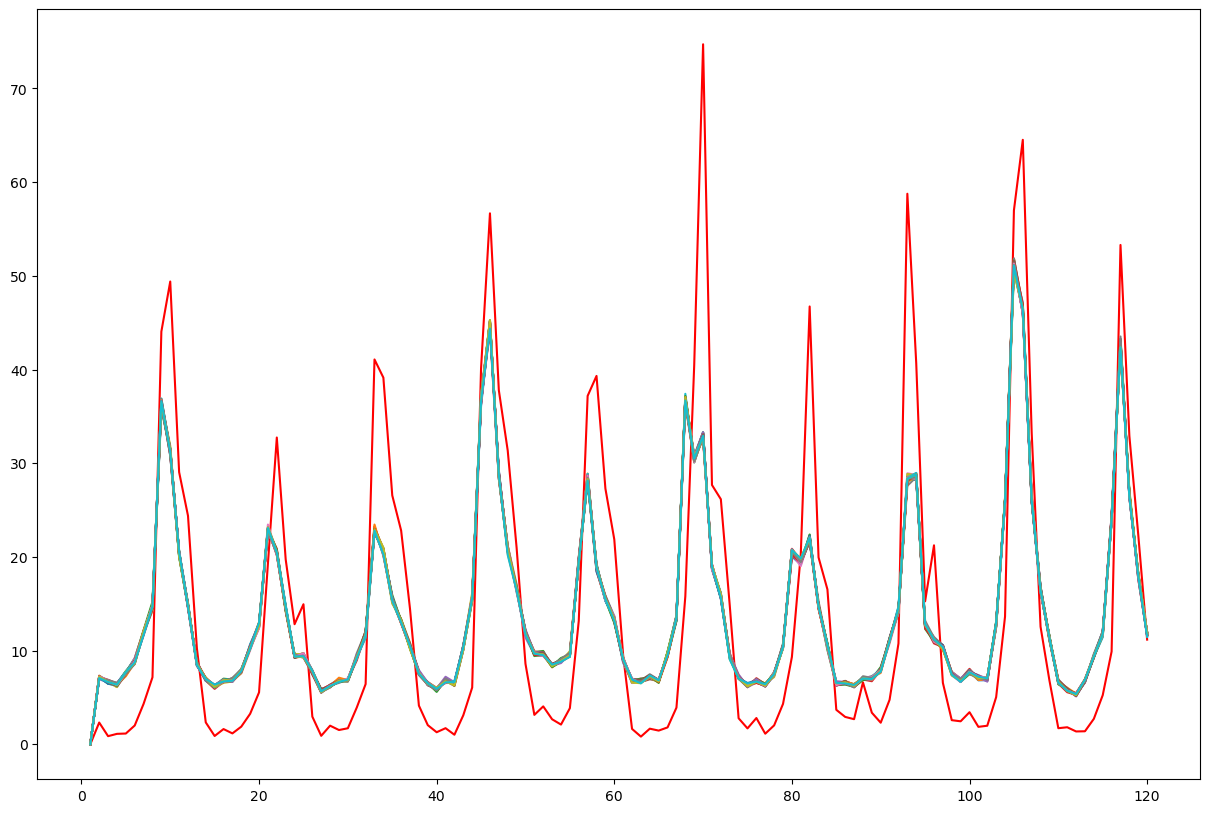

In [86]:

plt.figure(figsize=(15, 10))
plt.plot(range(1, T_value+1), np.array([sum(FS[(i-1)*n_munic: i*n_munic])/n_munic for i in range(T_value)]), color='r')
for i in range(30):
    plt.plot(range(1, T_value+1), PPC_FS_month_tot[i*100])
plt.show()

# Small Model

In [38]:

with pm.Model(coords={"area_idx": np.arange(data_length)}) as car_model:
    beta0 = pm.Normal("beta0", mu=0.0, tau=1.0e-5)
    beta1 = pm.Normal("beta1", mu=0.0, tau=1.0e-5)
    beta2 = pm.Normal("beta2", mu=0.0, tau=1.0e-5)
    beta3 = pm.Normal("beta3", mu=0.0, tau=1.0e-5)

    alpha = pm.Normal("alpha", mu=0, tau=1.0e-3)

    # exponential of the linear predictor -> the mean of the likelihood
    mu = pm.Deterministic("mu", pt.exp(beta0 + beta1*LUT + beta2*HUMID + beta3*TEMP + (alpha)*(t-(T_value/2+0.5))/T_value)*area, dims="area_idx")

    # likelihood of the observed data
    y_i = pm.Poisson("y_i", mu=mu, observed=FS, dims="area_idx")

    # sampling the model
    small_idata = pm.sample(1000, tune=500, return_inferencedata=True, idata_kwargs={"log_likelihood": True}, progressbar=True,
                      initvals={"beta0": -7.6, "beta1": -0.0047, "beta2": -0.0622, "beta3": 0.0211,"alpha": -0.417})
    

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta0, beta1, beta2, beta3, alpha]


Output()

Sampling 4 chains for 500 tune and 1_000 draw iterations (2_000 + 4_000 draws total) took 1644 seconds.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [55]:

subset_small_idata = small_idata.sel(chain=[0, 2, 3])



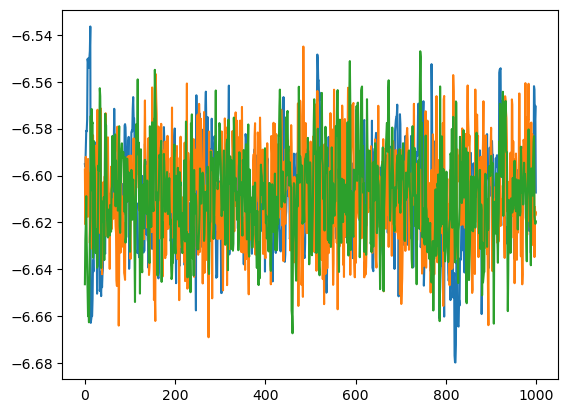

In [ ]:

plt.figure()
for i in range(3):
    plt.plot(range(len(subset_small_idata.posterior.beta0[i])), subset_small_idata.posterior.beta0[i])
plt.show()

In [58]:
waic_small_model = az.waic(subset_small_idata)

print(waic_small_model)

Computed from 3000 posterior samples and 66960 observations log-likelihood matrix.

          Estimate       SE
elpd_waic -1208581.91  22043.01
p_waic     1807.82        -

There has been a warning during the calculation. Please check the results.


/opt/anaconda3/envs/pymc_env/lib/python3.12/site-packages/arviz/stats/stats.py:1653: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


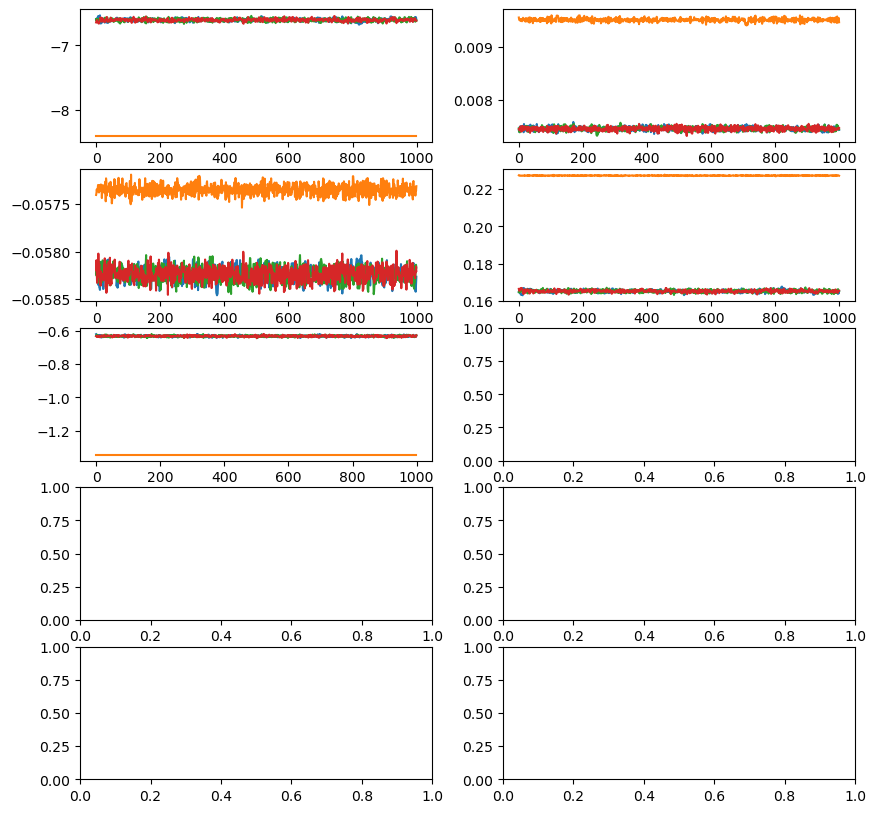

In [39]:

labels = [r"$\beta_0$", r"$\beta_{\text{LUT}}$", r"$\beta_{\text{Humid}}$", r"$\beta_{\text{Temp}}$",
          r"$\beta_{\text{Prec}}$", r"$\beta_{\text{Speed}}$", r"$\alpha$"]

fig, axes = plt.subplots(5, 2, figsize=(10, 10))

axes = axes.flatten()

for i in range(4): 
    axes[0].plot(range(len(small_idata.posterior.beta0[i])),small_idata.posterior.beta0[i])

for i in range(4): 
    axes[1].plot(range(len(small_idata.posterior.beta1[i])),small_idata.posterior.beta1[i])

for i in range(4): 
    axes[2].plot(range(len(small_idata.posterior.beta2[i])),small_idata.posterior.beta2[i])

for i in range(4): 
    axes[3].plot(range(len(small_idata.posterior.beta3[i])),small_idata.posterior.beta3[i])

for i in range(4): 
    axes[4].plot(range(len(small_idata.posterior.alpha[i])),small_idata.posterior.alpha[i])

plt.show()

In [60]:

beta0 = subset_small_idata.posterior.beta0.values.flatten()
beta1 = subset_small_idata.posterior.beta1.values.flatten()
beta2 = subset_small_idata.posterior.beta2.values.flatten()
beta3 = subset_small_idata.posterior.beta3.values.flatten()
alpha = subset_small_idata.posterior.alpha.values.flatten()

current_time = datetime.now()
formatted_time = current_time.strftime("%H:%M")

df = pd.DataFrame({
    "beta0": beta0,
    "beta_LUT": beta1,
    "beta_Humid": beta2,
    "beta_TEMP": beta3,
    "alpha": alpha,
})

# Save to CSV
df.to_csv("csv/samples_small"+str(formatted_time)+".csv", index=False)
